In [211]:
import pandas as pd
import numpy as np

from math import sqrt
import random

import collections

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [6]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def katz_centrality(G, alpha=1, beta=1, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n, 1.0/len(G.nodes())) for n in G.nodes()]) 
    else: 
        x = nstart 

    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast, 0)
  
        # do the multiplication y^T = x^T A 
        for n in x.keys(): 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)

        # apply alpha and beta
        for n in x:
            x[n] = alpha * x[n] + beta[n]
            
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) # this should never be zero
        except ZeroDivisionError: 
            s = 1.0

        for n in x: 
            x[n] *= s 
            
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
        
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [2]:
# build interactome network
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

In [4]:
# get MMAF candidate genes list
candidates_MMAF_tmp = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF_tmp if c in G.nodes()]

nonCandidates_MMAF = [n for n in list(G.nodes) if n not in candidates_MMAF]

In [119]:
# beta = number of candidate genes in neighbourhood / node degree
beta_dict = dict([(n, 10*len(candidates_in_neighbourhood(G, candidates_MMAF, n))/G.degree(n)) for n in G])

In [194]:
# beta = boolean of whether the ene is a MMAF candidate
beta_dict = dict([(n, int(n in candidates_MMAF)) for n in G])

In [7]:
# beta = 0
beta_dict = dict([(n, 0) for n in G])

In [146]:
# beta = number of candidate genes in neighbourhood / node degree + isCandidate
beta_dict = dict([(n, 10*(len(candidates_in_neighbourhood(G, candidates_MMAF, n))/G.degree(n) + int(n in candidates_MMAF))) for n in G])

In [54]:
# beta = [ number of candidate genes in neighbourhood + isCandidate NORMALIZED ] / node degree
beta_dict = dict([(n, 10*(len(candidates_in_neighbourhood(G, candidates_MMAF, n)) + int(n in candidates_MMAF))/G.degree(n)) for n in G])

In [72]:
# beta = (1 - alpha) / N
beta_dict = dict([(n,  0.5/len(G.nodes())) if n in candidates_MMAF else (n, 0) for n in G.nodes()])

In [46]:
# beta = number of candidate genes in neighbourhood / node degree + isCandidate
beta_1 = 3
beta_2 = 0.4
beta_dict = dict([(n, beta_1*len(candidates_in_neighbourhood(G, candidates_MMAF, n))/G.degree(n) + beta_2*int(n in candidates_MMAF)) for n in G])

In [124]:
# calculate Katz centrality
res = katz_centrality(G, alpha=0.5, beta=beta_dict)

res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))
res_sorted

6.91323885240235e-05
0.27750015182344057
0.27299199087038617
0.2719760080894366
0.27172805018472856
0.27163321177175137
0.27159614779455193
0.27158061434727737


In [127]:
# plot histogram of Katz centralities
evc_list = [v for k, v in res.items()]
min(evc_list), max(evc_list)

plt.hist(evc_list, bins=100)
plt.xlim()

(7.809617122974083e-20, 0.27157398306235864)

In [129]:
# get more info about each node
d = {}

for n, kc in res_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])

In [119]:
df

,KC,degree,candidates in N,isCandidate
ENSG00000180376,1.112230e-01,1,1,False
ENSG00000165556,1.102216e-01,1,1,False
ENSG00000187753,1.102216e-01,1,1,False
ENSG00000171135,9.207888e-02,103,0,False
ENSG00000168958,8.925759e-02,97,0,False
...,...,...,...,...
ENSG00000149043,9.659864e-113,2,0,False
ENSG00000166557,9.659864e-113,2,0,False
ENSG00000120332,9.659864e-113,2,0,False
ENSG00000146555,9.659864e-113,2,0,False


([<matplotlib.axis.XTick at 0x7fe6a78043d0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

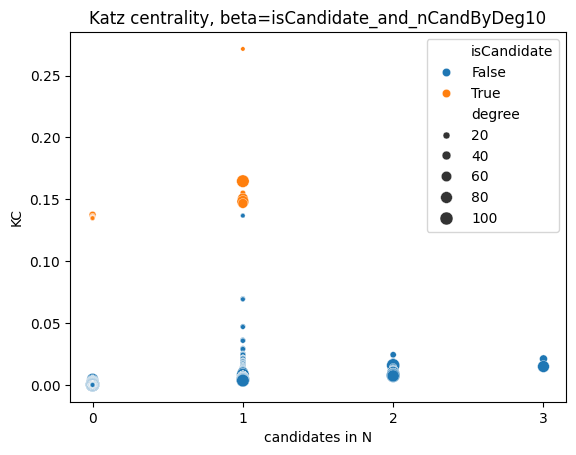

In [131]:
# plot KC vs number of MMAF candidates in direct neighbourhood of each node
sns.scatterplot(data=df, x="candidates in N", y="KC", hue='isCandidate', size='degree', sizes=(10, 100))
plt.title("Katz centrality, beta=isCandidate_and_nCandByDeg10")
plt.xticks(np.asarray([i for i in range(0, 4)]))

<Axes: xlabel='candidates in N', ylabel='KC'>

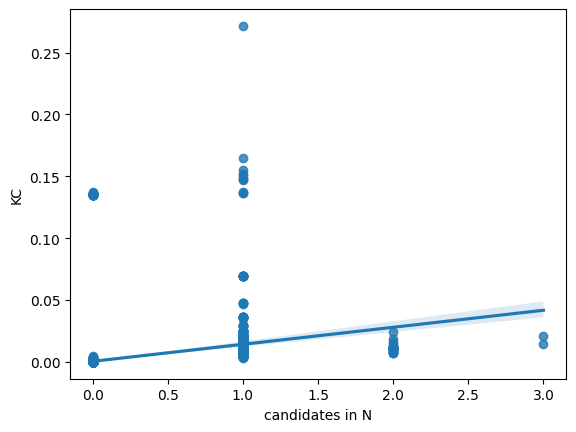

In [132]:
sns.regplot(data=df, x="candidates in N", y="KC")

<Axes: xlabel='degree', ylabel='KC'>

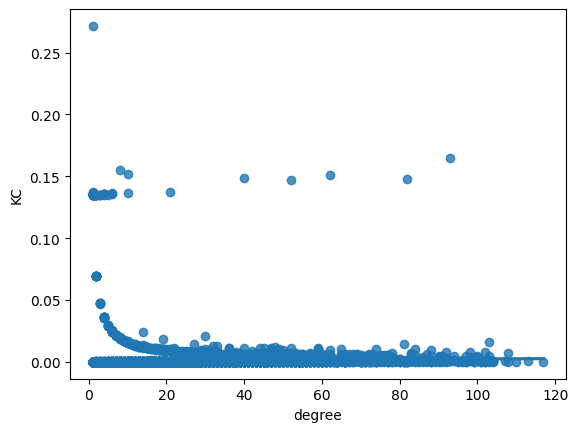

In [133]:
sns.regplot(data=df, x="degree", y="KC")

In [134]:
# get top 15 genes
df.iloc[:15]

,KC,degree,candidates in N,isCandidate
ENSG00000137473,0.271574,1,1,True
ENSG00000174799,0.164671,93,1,True
ENSG00000096872,0.155094,8,1,True
ENSG00000140623,0.151575,10,1,True
ENSG00000066185,0.150704,62,1,True
ENSG00000272514,0.148553,40,1,True
ENSG00000141013,0.148200,82,1,True
ENSG00000135205,0.146675,52,1,True
ENSG00000185658,0.137474,21,0,True
ENSG00000180376,0.136991,1,1,False


Text(0.5, 1.0, 'Katz centrality for top 15 genes, beta=isCandidate_and_nCandByDeg10')

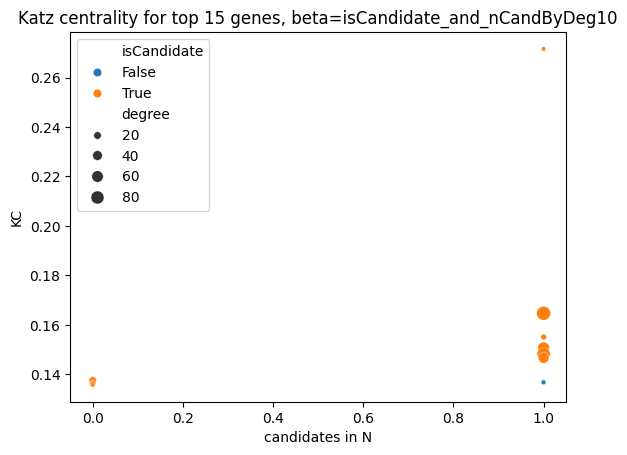

In [135]:
sns.scatterplot(data=df.iloc[:15], x="candidates in N", y="KC", hue='isCandidate', size='degree', sizes=(10, 100))
plt.title("Katz centrality for top 15 genes, beta=isCandidate_and_nCandByDeg10")

In [136]:
# get top 15 genes that are not candidates
df[df['isCandidate'] == False].iloc[:15]

,KC,degree,candidates in N,isCandidate
ENSG00000180376,0.136991,1,1,False
ENSG00000165556,0.136774,1,1,False
ENSG00000187753,0.136774,1,1,False
ENSG00000120278,0.069818,2,1,False
ENSG00000141933,0.069757,2,1,False
ENSG00000178295,0.069631,2,1,False
ENSG00000076650,0.069623,2,1,False
ENSG00000176225,0.069621,2,1,False
ENSG00000146842,0.069618,2,1,False
ENSG00000205922,0.069433,2,1,False


### Leave-one-out experiments

In [266]:
# remove one candidate from candidate list at random
random_idx = random.randint(0, len(candidates_MMAF))
left_out = candidates_MMAF[random_idx]

candidates_MMAF_new = candidates_MMAF[:random_idx] + candidates_MMAF[random_idx+1:]

print(f"Removed gene {left_out} from candidates")
print(f"Info: degree: {G.degree(left_out)}, candidates in N: {len(candidates_in_neighbourhood(G, candidates_MMAF_new, left_out))}")

Removed gene ENSG00000188738 from candidates
Info: degree: 1, candidates in N: 0


In [275]:
# get its neighbour
[n for n in G.neighbors('ENSG00000188738')]

['ENSG00000146223']

In [267]:
# set parameters alpha and beta
alpha = 0.1
beta = 1

In [277]:
# calculate KC for each node
beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])
res = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [278]:
# get more info about each node
d = {}

for n, kc in res_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df

,KC,degree,candidates in N,isCandidate
ENSG00000174799,1.638281e-01,93,1,True
ENSG00000141013,1.636609e-01,82,1,True
ENSG00000135205,1.623961e-01,52,1,True
ENSG00000066185,1.620769e-01,62,1,True
ENSG00000272514,1.611539e-01,40,1,True
...,...,...,...,...
ENSG00000149043,3.983152e-21,2,0,False
ENSG00000166557,3.983152e-21,2,0,False
ENSG00000120332,3.983152e-21,2,0,False
ENSG00000146555,3.983152e-21,2,0,False


In [279]:
df.loc['ENSG00000146223']

KC                 0.002559
degree                    8
candidates in N           0
isCandidate           False
Name: ENSG00000146223, dtype: object

Text(0.5, 1.0, 'Katz centrality, alpha=0.1, beta=1')

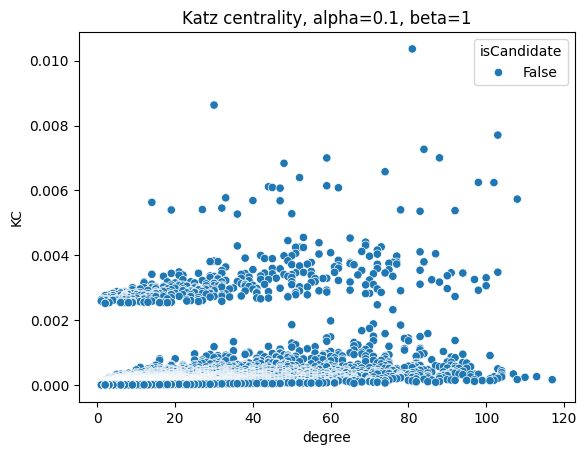

In [270]:
# sns.scatterplot(data=df, x="degree", y="KC", hue="isCandidate")
# analyze only non-candidates
sns.scatterplot(data=df[df['isCandidate'] == False], x="degree", y="KC", hue="isCandidate")
plt.title(f"Katz centrality, alpha={alpha}, beta={beta}")

([<matplotlib.axis.XTick at 0x7f52278fa2e0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

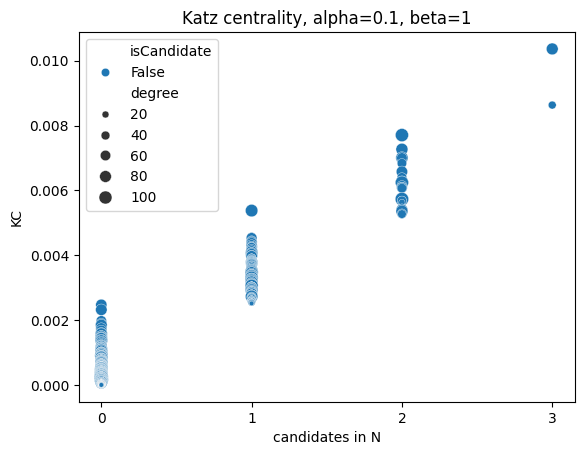

In [271]:
# sns.scatterplot(data=df, x="candidates in N", y="KC", hue='isCandidate', size='degree', sizes=(10, 100))
# analyze only non-candidates
sns.scatterplot(data=df[df['isCandidate'] == False], x="candidates in N", y="KC", hue='isCandidate', size='degree', sizes=(10, 100))
plt.title(f"Katz centrality, alpha={alpha}, beta={beta}")
plt.xticks(np.asarray([i for i in range(0, 4)]))

Text(0.1, 1.668975180053953e-06, 'left out: ENSG00000188738, KC=1.668975180053953e-06')

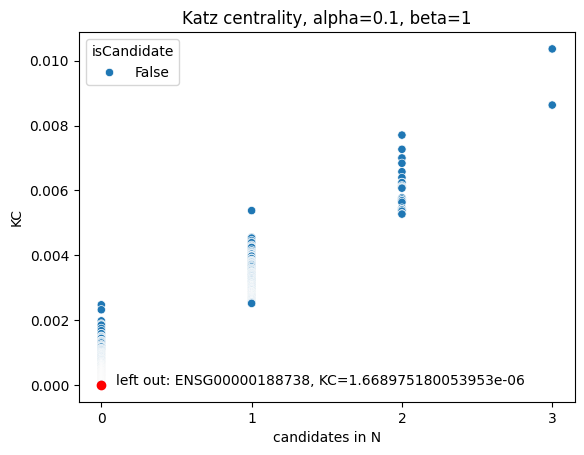

In [272]:
# sns.scatterplot(data=df, x="candidates in N", y="KC", hue='isCandidate')
# analyze only non candidates
sns.scatterplot(data=df[df['isCandidate'] == False], x="candidates in N", y="KC", hue='isCandidate')
plt.title(f"Katz centrality, alpha={alpha}, beta={beta}")
plt.xticks(np.asarray([i for i in range(0, 4)]))

# plot the left-out gene
x = df.loc[left_out]['candidates in N']
y = df.loc[left_out]['KC']
plt.plot(x, y, 'ro')
plt.text(x+0.1, y, s=f"left out: {left_out}, KC={y}")

In [179]:
# get more info about left-out candidate
df.loc[left_out]

KC                 0.002496
degree                    8
candidates in N           1
isCandidate           False
Name: ENSG00000096872, dtype: object

In [178]:
# get all nodes at distance k from a node
nx.single_source_shortest_path_length(G, left_out, cutoff=3)

{'ENSG00000096872': 0,
 'ENSG00000122970': 1,
 'ENSG00000196544': 1,
 'ENSG00000174799': 1,
 'ENSG00000101004': 1,
 'ENSG00000073584': 1,
 'ENSG00000196553': 1,
 'ENSG00000205726': 1,
 'ENSG00000150477': 1,
 'ENSG00000080986': 2,
 'ENSG00000104695': 2,
 'ENSG00000142149': 2,
 'ENSG00000187535': 2,
 'ENSG00000116711': 2,
 'ENSG00000151491': 2,
 'ENSG00000172680': 2,
 'ENSG00000132879': 2,
 'ENSG00000146414': 2,
 'ENSG00000047579': 2,
 'ENSG00000175203': 2,
 'ENSG00000126777': 2,
 'ENSG00000126001': 2,
 'ENSG00000137831': 2,
 'ENSG00000185963': 2,
 'ENSG00000072864': 2,
 'ENSG00000166579': 2,
 'ENSG00000149357': 2,
 'ENSG00000116586': 2,
 'ENSG00000013810': 2,
 'ENSG00000138160': 2,
 'ENSG00000136861': 2,
 'ENSG00000076382': 2,
 'ENSG00000122417': 2,
 'ENSG00000138180': 2,
 'ENSG00000128944': 2,
 'ENSG00000100503': 2,
 'ENSG00000108395': 2,
 'ENSG00000105700': 2,
 'ENSG00000083535': 2,
 'ENSG00000101997': 2,
 'ENSG00000123595': 2,
 'ENSG00000146457': 2,
 'ENSG00000077348': 2,
 'ENSG00000

In [95]:
# get top 15 genes that are not candidates
df[df['isCandidate'] == False].iloc[:15]

,KC,degree,candidates in N,isCandidate
ENSG00000084652,0.010365,81,3,False
ENSG00000150477,0.008633,30,3,False
ENSG00000101004,0.007707,103,2,False
ENSG00000223501,0.007268,84,2,False
ENSG00000135249,0.007005,88,2,False
ENSG00000140743,0.007001,59,2,False
ENSG00000152404,0.006837,48,2,False
ENSG00000136146,0.006577,74,2,False
ENSG00000196544,0.006396,52,2,False
ENSG00000101624,0.006247,98,2,False


In [96]:
# Let's try to divide KC by deg(node)
df['KC / degree'] = df['KC'] / df['degree']
df.sort_values(by='KC / degree', ascending=False)

,KC,degree,candidates in N,isCandidate,KC / degree
ENSG00000137473,1.611350e-01,1,1,True,1.611350e-01
ENSG00000181378,1.586230e-01,1,0,True,1.586230e-01
ENSG00000077327,1.586178e-01,1,0,True,1.586178e-01
ENSG00000105792,1.586178e-01,1,0,True,1.586178e-01
ENSG00000124721,1.586171e-01,1,0,True,1.586171e-01
...,...,...,...,...,...
ENSG00000170962,7.052765e-23,2,0,False,3.526383e-23
ENSG00000138622,7.052765e-23,2,0,False,3.526383e-23
ENSG00000167723,7.052765e-23,2,0,False,3.526383e-23
ENSG00000196433,7.052765e-23,2,0,False,3.526383e-23


Text(0.1, 1.668975180053953e-06, 'left out: ENSG00000188738, KC=1.668975180053953e-06')

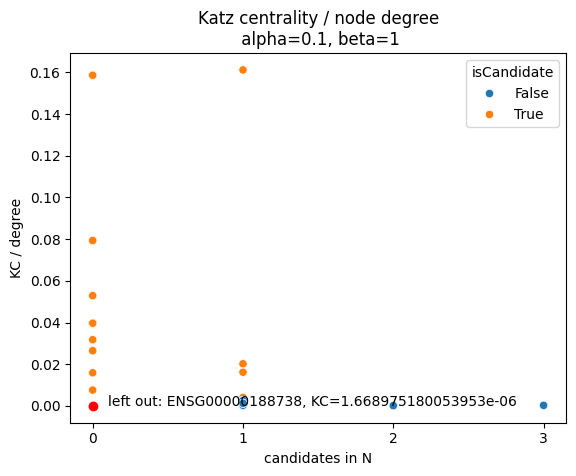

In [97]:
# plt KC divided by deg(node)
sns.scatterplot(data=df, x="candidates in N", y="KC / degree", hue='isCandidate')
plt.title(f"Katz centrality / node degree\n alpha={alpha}, beta={beta}")
plt.xticks(np.asarray([i for i in range(0, 4)]))

# plot the left-out gene
x = df.loc[left_out]['candidates in N']
y = df.loc[left_out]['KC'] / G.degree(left_out)
plt.plot(x, y, 'ro')
plt.text(x+0.1, y, s=f"left out: {left_out}, KC={y}")

### Leave-one-out one random candidate at a time for 16 chosen candidates 

In [103]:
candidates_MMAF = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF if c in G.nodes()]
len(candidates_MMAF)

41

In [104]:
# set parameters alpha and beta
alpha = 0.1
beta = 1

Removed gene ENSG00000159625 from candidates
Removed gene ENSG00000206530 from candidates
Removed gene ENSG00000124721 from candidates
Removed gene ENSG00000140623 from candidates
Removed gene ENSG00000206530 from candidates
Removed gene ENSG00000124721 from candidates
Removed gene ENSG00000140623 from candidates
Removed gene ENSG00000118690 from candidates
Removed gene ENSG00000124721 from candidates
Removed gene ENSG00000140623 from candidates
Removed gene ENSG00000118690 from candidates
Removed gene ENSG00000142609 from candidates
Removed gene ENSG00000140623 from candidates
Removed gene ENSG00000118690 from candidates
Removed gene ENSG00000142609 from candidates
Removed gene ENSG00000077327 from candidates


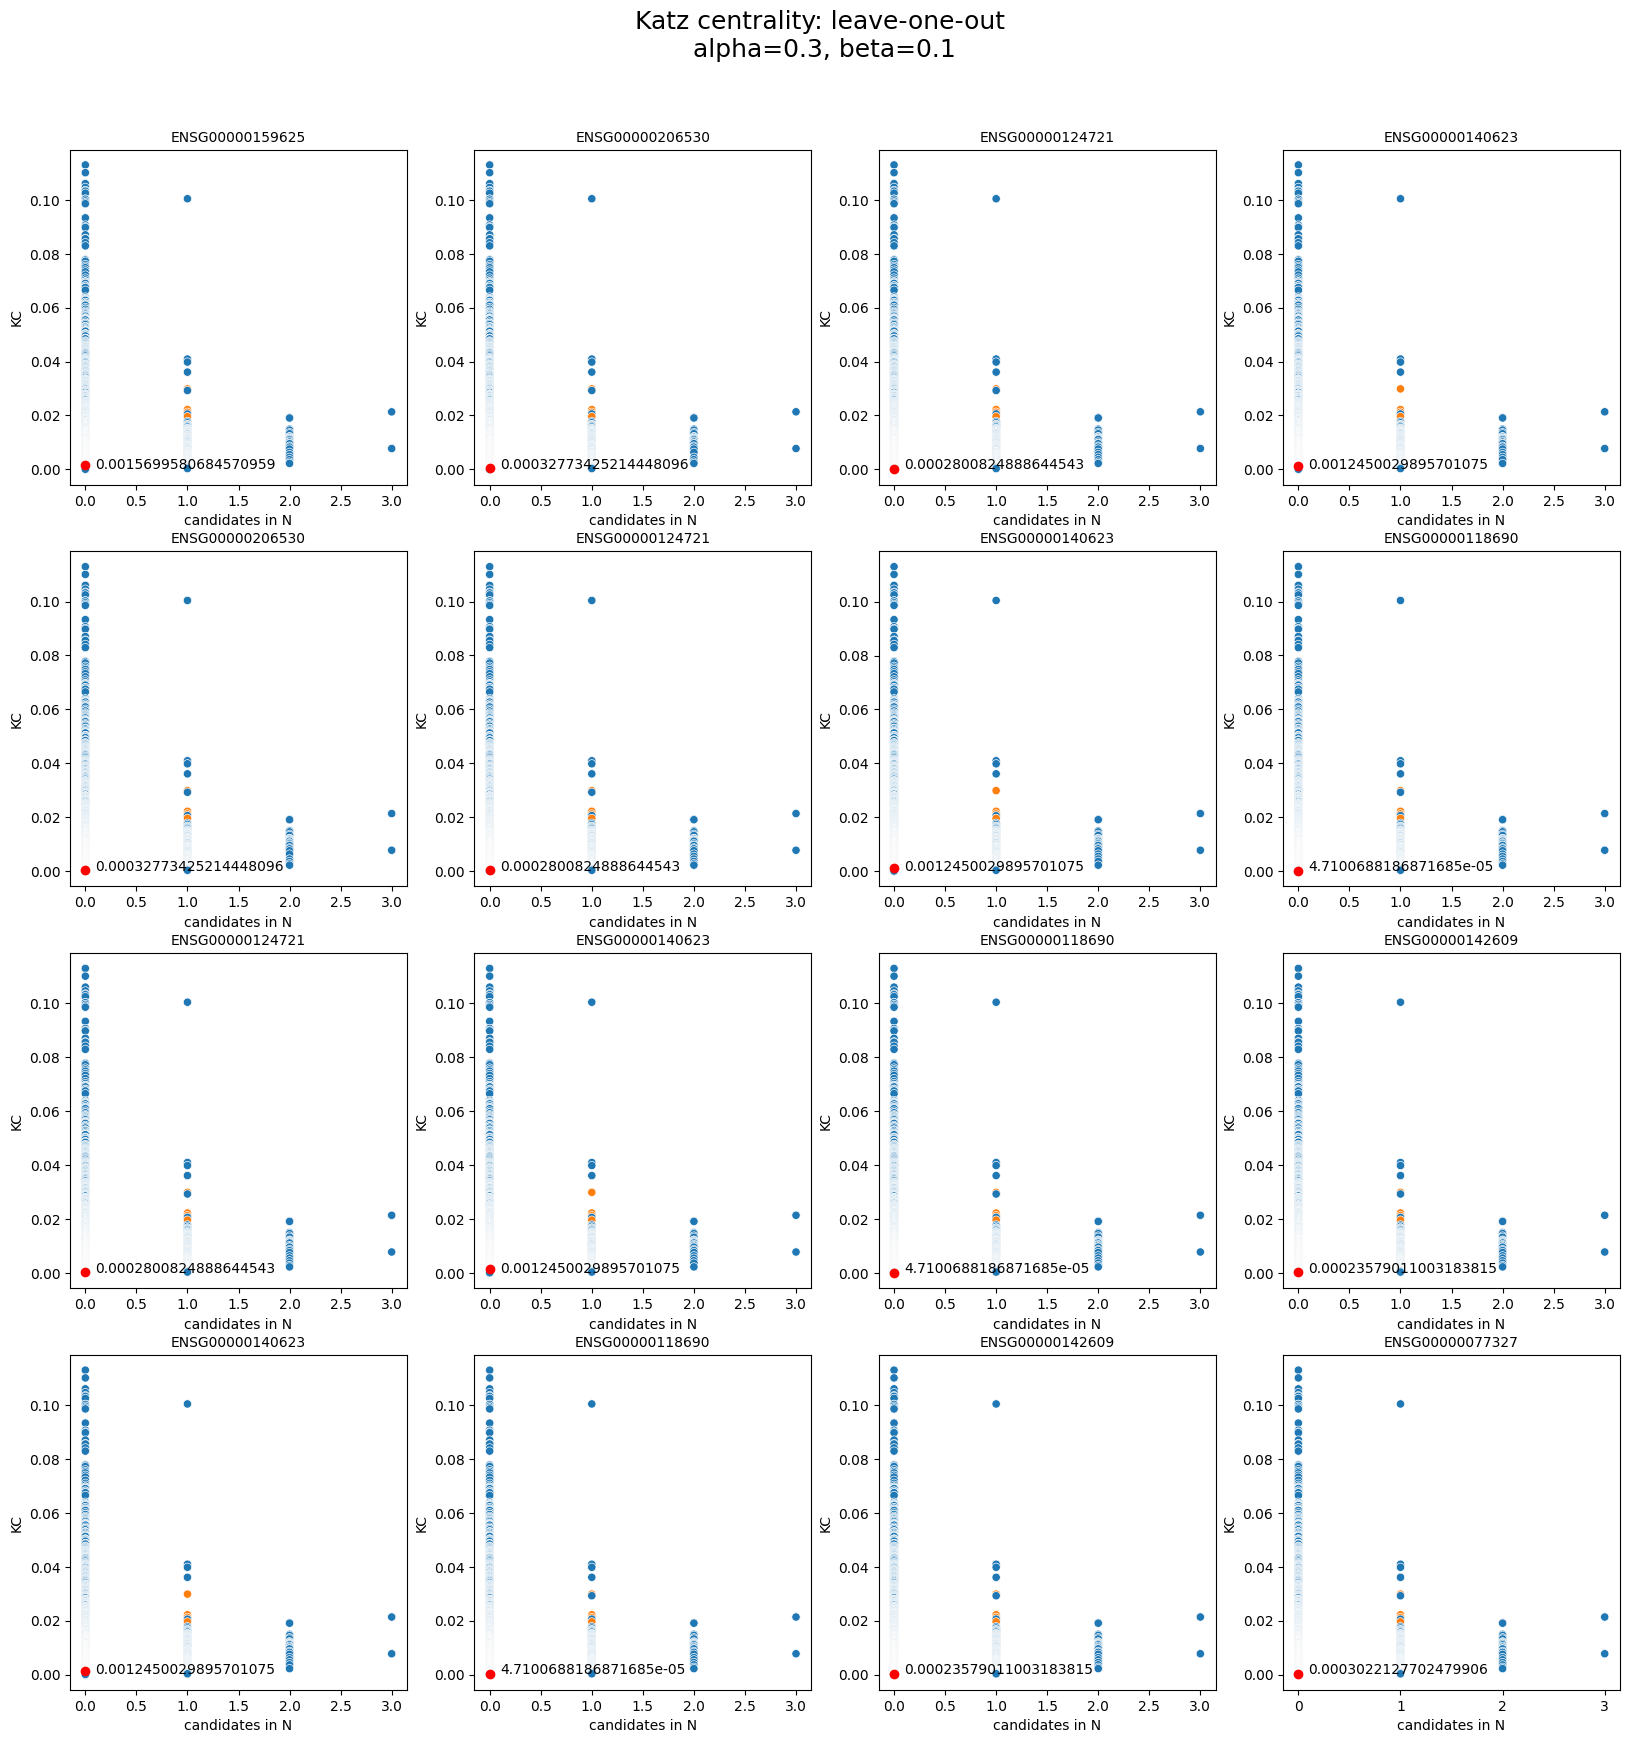

In [74]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle(f"Katz centrality: leave-one-out\n alpha={alpha}, beta={beta}", fontsize=18, y=0.95)

# get a list of indices to remove from candidates list
random_idx_list = random.sample(range(len(candidates_MMAF)), 16)

# create a dictionary to save KC for left-out candidates
dict_candidates = {}

for i in range(4):
    for j in range(4):
        # remove one candidate from candidate list
        random_idx = random_idx_list[i+j]
        left_out = candidates_MMAF[random_idx]

        candidates_MMAF_new = candidates_MMAF[:random_idx] + candidates_MMAF[random_idx+1:]

        print(f"Removed gene {left_out} from candidates")

        # set beta parameter for each node
        beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])

        # calculate Katz centrality for each node
        res = katz_centrality(G, alpha=alpha, beta=beta_dict)
        res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

        # get more info about each node
        d = {}

        for n, kc in res_sorted.items():
            d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

        df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])

        # plot the results
        sns.scatterplot(data=df, x="candidates in N", y="KC", hue='isCandidate', ax=ax[i, j])
        plt.xticks(np.asarray([i for i in range(0, 4)]))
        
        # plot the left-out gene
        x = df.loc[left_out]['candidates in N']
        KC = df.loc[left_out]['KC']

        ax[i, j].plot(x, KC, 'ro')
        ax[i, j].text(x+0.1, y, s=f"{KC}")
        ax[i, j].legend().remove()
        ax[i, j].set_title(left_out, fontsize=10)

        # add left-out candidate KC to dict_candidates
        dict_candidates[left_out] = KC
        
plt.show()

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'KC')

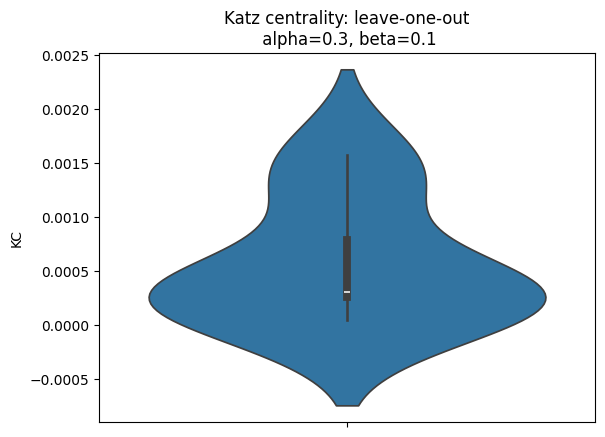

In [75]:
# violin plot plot of KC for left-out candidates
sns.violinplot(data=dict_candidates)
plt.title(f"Katz centrality: leave-one-out\n alpha={alpha}, beta={beta}")
plt.ylabel("KC")

### Leave-one-out one candidate at a time for all candidates 

In [105]:
candidates_MMAF = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF if c in G.nodes()]
len(candidates_MMAF)

41

In [166]:
# set parameters alpha and beta
alpha = 0.1
beta = 0.05

In [167]:
# list of indices to visit
l = [x for x in range(len(candidates_MMAF))]

# create a dictionary to save KC for left-out candidates
dict_candidates = {}

Removed gene ENSG00000066185 from candidates
Removed gene ENSG00000157796 from candidates
Removed gene ENSG00000137473 from candidates
Removed gene ENSG00000168026 from candidates
Removed gene ENSG00000130413 from candidates
Removed gene ENSG00000152582 from candidates
Removed gene ENSG00000077327 from candidates
Removed gene ENSG00000140623 from candidates
Removed gene ENSG00000129646 from candidates
Removed gene ENSG00000096872 from candidates


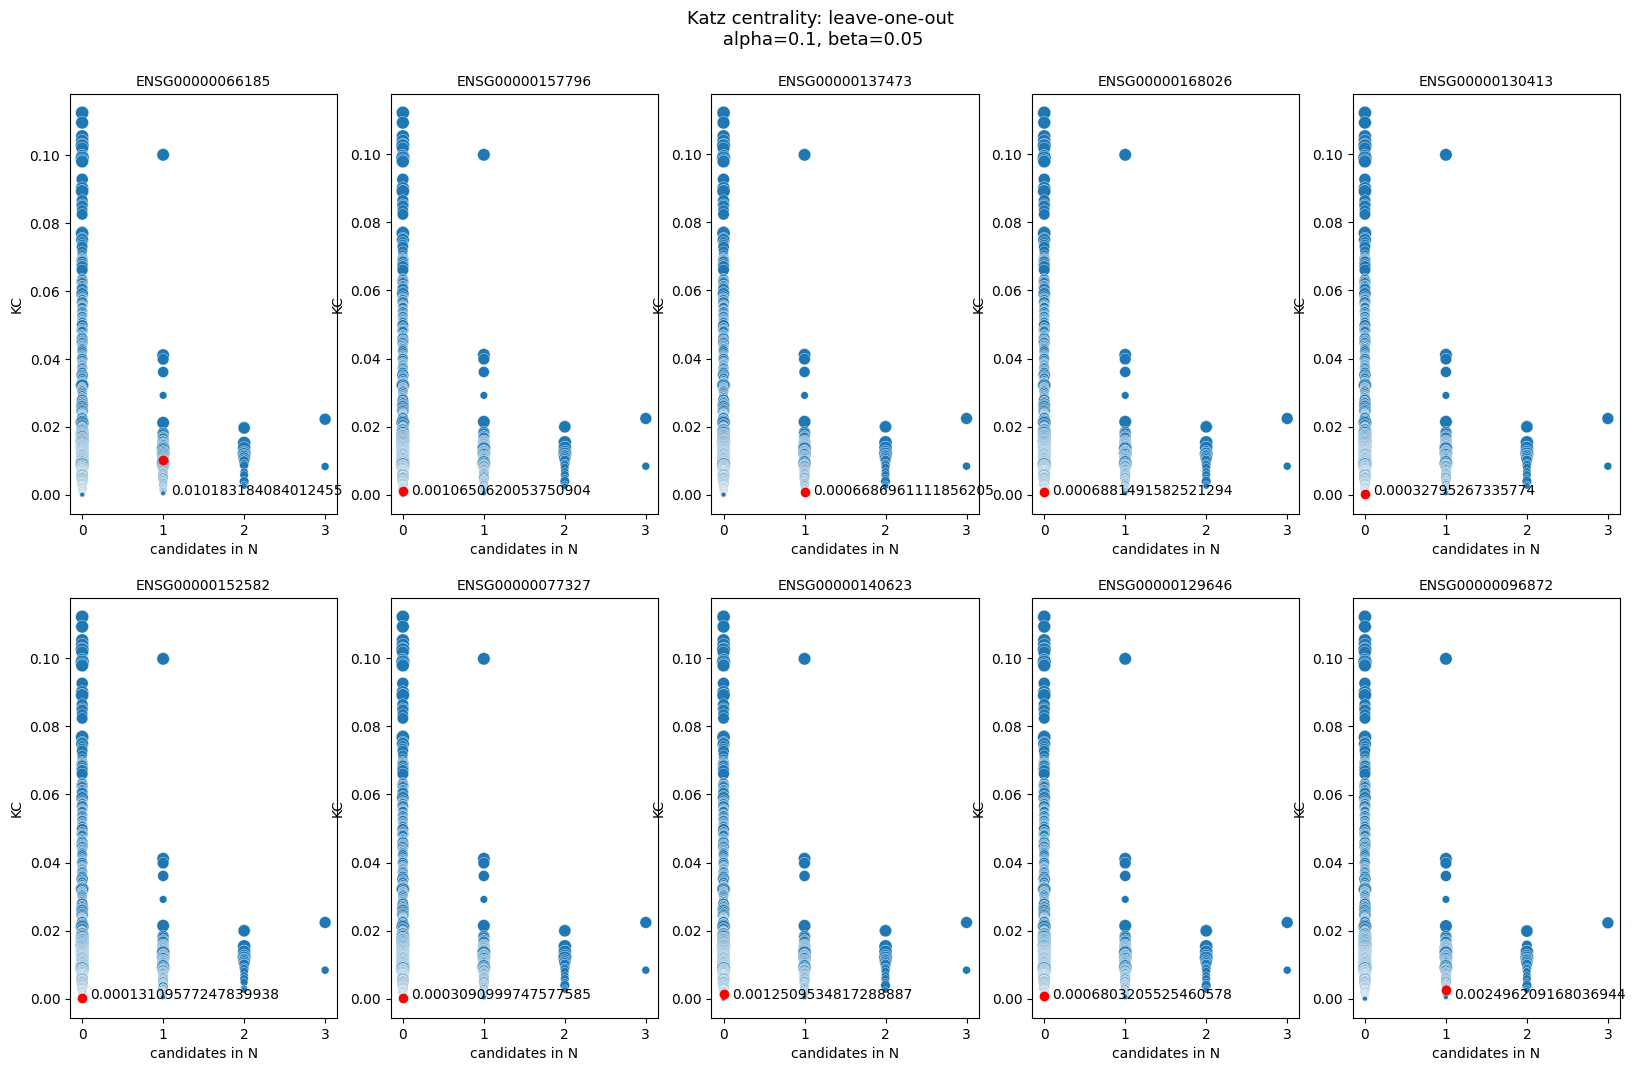

In [168]:
fig, ax = plt.subplots(2, 5, figsize=(20, 12))
fig.suptitle(f"Katz centrality: leave-one-out\n alpha={alpha}, beta={beta}", fontsize=13, y=0.95)

for i in range(2):
    for j in range(5):
        # remove one candidate from candidate list
        left_out_idx = l.pop(-1)
        left_out = candidates_MMAF[left_out_idx]

        candidates_MMAF_new = candidates_MMAF[:left_out_idx] + candidates_MMAF[left_out_idx+1:]

        print(f"Removed gene {left_out} from candidates")

        # set beta parameter for each node
        beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])

        # calculate Katz centrality for each node
        res = katz_centrality(G, alpha=alpha, beta=beta_dict)
        res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

        # get more info about each node
        d = {}

        for n, kc in res_sorted.items():
            d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

        df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])

        # plot the results
        sns.scatterplot(data=df[df['isCandidate'] == False], x="candidates in N", y="KC", hue='isCandidate', size='degree', sizes=(10, 100), ax=ax[i, j])
        plt.xticks(np.asarray([i for i in range(0, 4)]))
        
        # plot the left-out gene
        x = df.loc[left_out]['candidates in N']
        KC = df.loc[left_out]['KC']

        ax[i, j].plot(x, KC, 'ro')
        ax[i, j].text(x+0.1, y, s=f"{KC}")
        ax[i, j].legend().remove()
        ax[i, j].set_title(left_out, fontsize=10)

        # add left-out candidate KC to dict_candidates
        dict_candidates[left_out] = KC

plt.show()

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.5, 'KC')

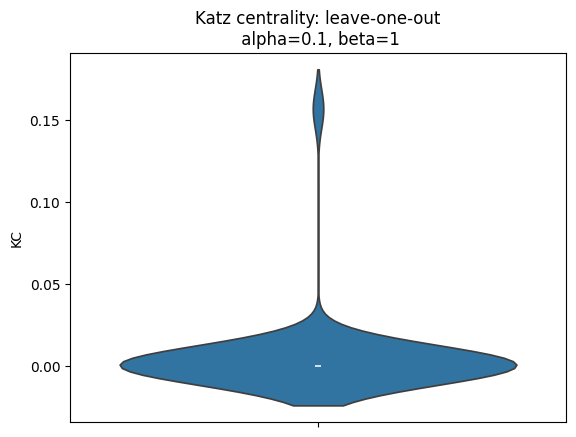

In [148]:
# violin plot plot of KC for left-out candidates
sns.violinplot(data=dict_candidates)
plt.title(f"Katz centrality: leave-one-out\n alpha={alpha}, beta={beta}")
plt.ylabel("KC")

Text(0.5, 0, 'KC')

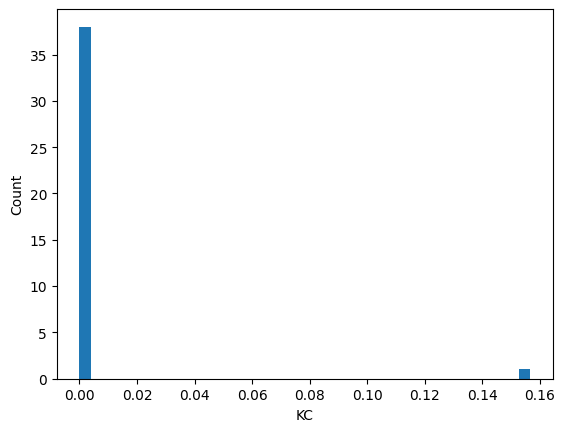

In [152]:
plt.hist(dict_candidates.values(), bins=len(dict_candidates.keys()))
plt.ylabel("Count")
plt.xlabel("KC")

### Analyze the results with GTEx testis ratio

In [43]:
# prepare GTEx data
gtex_df = pd.read_csv('./data/MMAF.Transcripts.patientIDs.Strelka.csv', sep='\t', on_bad_lines='skip')

gtex_list = []

for idx, row in df.iterrows():
    try:
        gtex_testis_ratio = gtex_df[gtex_df['Gene'].str.contains(idx)]['GTEX_testis_RATIO'].values[0]
        gtex_list.append(gtex_testis_ratio)
    except:
        gtex_list.append(0)

df['GTEX_testis_RATIO'] = gtex_list

Text(0.5, 1.0, 'Katz centrality, alpha=0.1, beta=0.2')

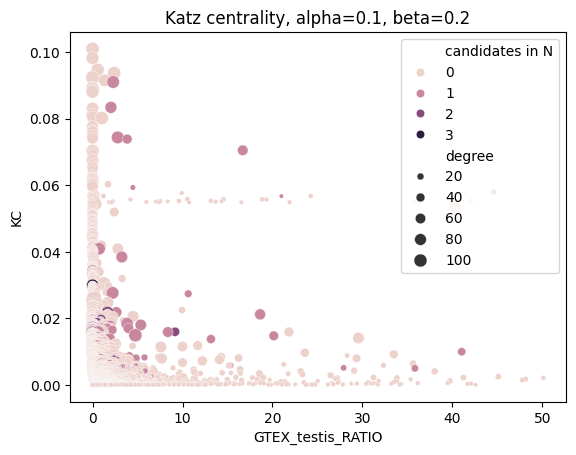

In [44]:
# plot KC vs GTEx ratio testis
sns.scatterplot(data=df, x="GTEX_testis_RATIO", y="KC", hue="candidates in N", size='degree', sizes=(10, 100))
plt.title(f"Katz centrality, alpha={alpha}, beta={beta}")

### Build interactome from genes with GTEX_testis_RATIO > x

In [281]:
gtex_limit = 2.0

In [236]:
# build interactome network
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

(14465, 92064)

In [237]:
G.nodes()

NodeView(('ENSG00000065559', 'ENSG00000128591', 'ENSG00000077522', 'ENSG00000138347', 'ENSG00000179348', 'ENSG00000140464', 'ENSG00000143761', 'ENSG00000125447', 'ENSG00000132254', 'ENSG00000134287', 'ENSG00000164144', 'ENSG00000149925', 'ENSG00000114127', 'ENSG00000173406', 'ENSG00000105290', 'ENSG00000137203', 'ENSG00000164442', 'ENSG00000084674', 'ENSG00000138823', 'ENSG00000141480', 'ENSG00000160271', 'ENSG00000175324', 'ENSG00000134440', 'ENSG00000123159', 'ENSG00000043591', 'ENSG00000099889', 'ENSG00000129910', 'ENSG00000014216', 'ENSG00000143801', 'ENSG00000092529', 'ENSG00000155657', 'ENSG00000178538', 'ENSG00000150995', 'ENSG00000170275', 'ENSG00000139687', 'ENSG00000073111', 'ENSG00000085840', 'ENSG00000115947', 'ENSG00000100297', 'ENSG00000097046', 'ENSG00000115942', 'ENSG00000006634', 'ENSG00000105127', 'ENSG00000164815', 'ENSG00000112118', 'ENSG00000080839', 'ENSG00000101773', 'ENSG00000108821', 'ENSG00000146674', 'ENSG00000112576', 'ENSG00000178982', 'ENSG00000134057', 'E

In [238]:
# prepare GTEx data
gtex_df = pd.read_csv('./data/MMAF.Transcripts.patientIDs.Strelka.csv', sep='\t', on_bad_lines='skip')

gtex_dict = {}

for node in G.nodes():
    try:
        gtex_testis_ratio = gtex_df[gtex_df['Gene'].str.contains(node)]['GTEX_testis_RATIO'].values[0]
        gtex_dict[node] = gtex_testis_ratio
    except:
        gtex_dict[node] = 0

gtex_dict_high = {k:v for k, v in gtex_dict.items() if v > gtex_limit}

In [ ]:
to_remove = [n for n, gtex in gtex_dict.items() if gtex < gtex_limit]
G_testis = G.copy()
G_testis.remove_nodes_from(to_remove)

In [206]:
G_testis.number_of_nodes(), G_testis.number_of_edges()

(390, 98)

Text(0, 0.5, 'number of nodes')

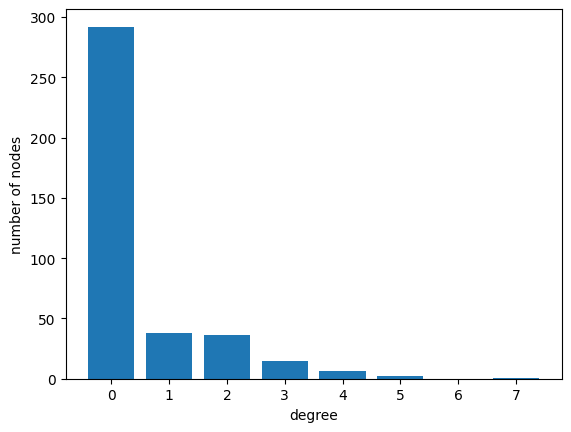

In [212]:
# degree histogram
degrees = sorted([d for n, d in G_testis.degree()])
deg, cnt = zip(*collections.Counter(degrees).items())

plt.bar(deg, cnt)
plt.xlabel("degree")
plt.ylabel("number of nodes")

In [213]:
candidates_MMAF_gtex = [candidate for candidate in candidates_MMAF if candidate in G_testis]

In [215]:
# calculate Katz centrality for testis interactome
# remove one candidate from candidate list at random
random_idx = random.randint(0, len(candidates_MMAF_gtex))
left_out = candidates_MMAF_gtex[random_idx]

candidates_MMAF_new = candidates_MMAF_gtex[:random_idx] + candidates_MMAF_gtex[random_idx+1:]

print(f"Removed gene {left_out} from candidates")
print(f"Info: degree: {G_testis.degree(left_out)}, candidates in N: {len(candidates_in_neighbourhood(G_testis, candidates_MMAF_new, left_out))}")

Removed gene ENSG00000111254 from candidates
Info: degree: 0, candidates in N: 0


In [216]:
# set parameters alpha and beta
alpha = 0.1
beta = 1

In [217]:
# calculate KC for each node
beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G_testis])
res = katz_centrality(G_testis, alpha=alpha, beta=beta_dict)
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [220]:
# get more info about each node
d = {}

for n, kc in res_sorted.items():
    d[n] = (kc, G_testis.degree(n), len(candidates_in_neighbourhood(G_testis, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df

,KC,degree,candidates in N,isCandidate
ENSG00000066185,0.207856,4,1,True
ENSG00000272514,0.207773,4,1,True
ENSG00000140623,0.207686,3,1,True
ENSG00000137473,0.207603,1,1,True
ENSG00000159625,0.203460,1,0,True
...,...,...,...,...
ENSG00000187867,0.000000,0,0,False
ENSG00000152591,0.000000,0,0,False
ENSG00000101680,0.000000,0,0,False
ENSG00000147799,0.000000,0,0,False


In [232]:
df[df['isCandidate'] == False].sort_values(by='KC', ascending=False).head(15)

,KC,degree,candidates in N,isCandidate
ENSG00000162148,0.004231,3,1,False
ENSG00000161180,0.004227,1,1,False
ENSG00000153060,0.004227,1,1,False
ENSG00000039600,0.004225,1,1,False
ENSG00000164512,0.004225,1,1,False
ENSG00000061656,0.004224,1,1,False
ENSG00000183690,0.004140,2,1,False
ENSG00000175294,0.000088,7,0,False
ENSG00000196155,0.000086,5,0,False
ENSG00000163071,0.000086,3,0,False


Text(0.1, 0.0, 'left out: ENSG00000111254, KC=0.0')

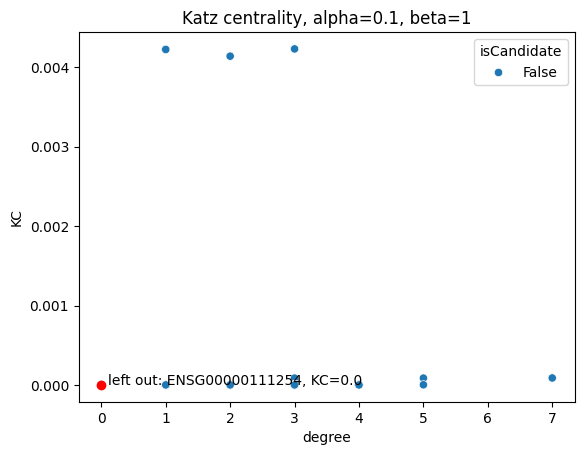

In [229]:
# sns.scatterplot(data=df, x="degree", y="KC", hue="isCandidate")
# analyze only non-candidates
sns.scatterplot(data=df[df['isCandidate'] == False], x="degree", y="KC", hue="isCandidate")
plt.title(f"Katz centrality, alpha={alpha}, beta={beta}")

# plot the left-out gene
x = df.loc[left_out]['degree']
y = df.loc[left_out]['KC']
plt.plot(x, y, 'ro')
plt.text(x+0.1, y, s=f"left out: {left_out}, KC={y}")